In [31]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score 
from dvc import api
from io import StringIO
from joblib import dump


# Cargar los datos y realizar el preprocesamiento
df_path = api.read('../dataset/data_prueba_limpia.csv', remote='dataset-track')
df_ml = pd.read_csv(StringIO(df_path))


# Eliminar las columnas 'target'  del DataFrame original y guardarlo en otro Df
df_target = df_ml[['target']]
df_ml = df_ml.drop(columns=['target'])

# Clusterización 
optimal_clusters= 4
scaler = StandardScaler()
df_ml_scaled = scaler.fit_transform(df_ml)
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
kmeans.fit(df_ml_scaled)
df_ml['cluster'] = kmeans.labels_

feature_means = df_ml.groupby('cluster').mean()
cluster_scores = feature_means.sum(axis=1)
sorted_clusters = cluster_scores.sort_values(ascending=False).index
cluster_map = {cluster: letter for cluster, letter in zip(sorted_clusters, 'ABCD')}
df_ml['cluster'] = df_ml['cluster'].map(cluster_map)

# PCA variables relacionadas
variables = ['decil_ingreso_ENIGH', 'liquidez_porcentual', 'costo_de_vida']
pca = PCA(n_components=1)
df_ml['ENIGH'] = pca.fit_transform(df_ml[variables])
df_ml = df_ml.drop(columns=variables)

# Reordenar las columnas del DataFrame
df_ml = df_ml[['ingreso',
               'antiguedad_laboral_meses',
                'tiempo_desempleado', 
                'trabajos_ultimos_5', 
                'semanasCotizadas', 
                'edad', 
                'crecimiento_ingreso', 
                'crecimiento_gral', 
                'ENIGH', 
                'cluster', 
                ]]

# concatenar los dfs
df_ml = pd.concat([df_ml, df_target], axis=1)

# Score y cluster
X = df_ml.drop(['target', 'cluster'], axis=1)
y_score = df_ml['target'] 
y_cluster = df_ml['cluster'] 

X_train, X_test, y_train_score, y_test_score = train_test_split(X, y_score, test_size=0.3, 
                                                                random_state=42)
y_train_cluster, y_test_cluster = train_test_split(y_cluster, test_size=0.3, random_state=42)

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Modelo de regresión Random Forest para predecir score crediticio
rf_reg = RandomForestRegressor(random_state=42)
rf_reg.fit(X_train_scaled, y_train_score)

# Modelo de clasificación Random Forest para predecir el cluster
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train_scaled, y_train_cluster)

RandomForestClassifier(random_state=42)

In [32]:
dump(rf_reg, '../model/model_reg.pkl')
dump(rf_clf, '../model/model_clf.pkl')
dump(scaler, '../model/model_scaler.pkl')

['../model/model_scaler.pkl']

In [33]:
predictions_score = rf_reg.predict(X_test_scaled)
mse = mean_squared_error(y_test_score, predictions_score)
r2 = r2_score(y_test_score, predictions_score)
print(f"Error cuadrático medio para la regresión: {mse}")
print(f"Coeficiente de determinación para la regresión: {r2}")

Error cuadrático medio para la regresión: 7.464290236156593e-05
Coeficiente de determinación para la regresión: 0.9957512181438563


In [34]:
# Modelo de clasificación Random Forest para predecir el cluster
predictions_cluster = rf_clf.predict(X_test_scaled)
accuracy = accuracy_score(y_test_cluster, predictions_cluster)
print(f"Precisión para la clasificación: {accuracy}") 

Precisión para la clasificación: 0.9826240241752707


In [35]:
with open('../report.txt', 'w') as report_file:
    report_file.write('# Random Forest Regressor Model'+'\n')
    report_file.write(f'### Mean square Error: {mse}'+'\n')
    report_file.write(f'### R2 Correlation Coefficient: {r2}'+'\n\n')
    report_file.write('# Random Forest Classifier Model'+'\n')
    report_file.write(f'### Accuracy: {accuracy}'+'\n')

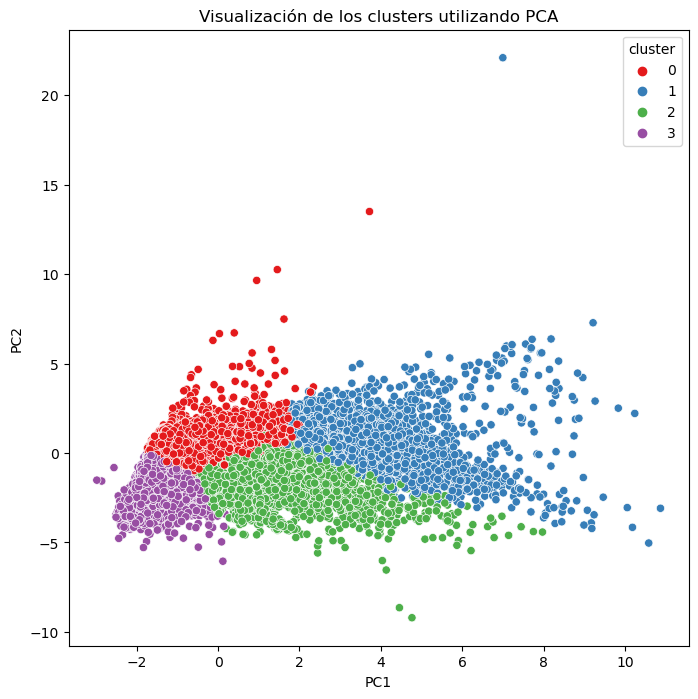

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
# Aplicar PCA a los datos para visualización en 2D
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_ml_scaled)
# Crear un DataFrame con los resultados de PCA y los clusters
df_pca = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
df_pca['cluster'] = kmeans.labels_
# Visualizar los clusters en un gráfico de dispersión utilizando PCA
fig, ax = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(8)
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='cluster', palette='Set1')
plt.title('Visualización de los clusters utilizando PCA')
plt.show()
fig.savefig('../cluster_behavior.png')